# Practical Classification

We will now looking at a problem that was examined in the regression tutorial. We will use the California housing prices dataset. Instead of predicting the exact price of the house, we are interested in the following question:

<i>For a given configuration, is a house likely to be priced high or low? </i>

Note that we have taken a regression problem and made it a classification problem. To formalize it as a  machine learning pproblem, we set a cutoff of $ 200,000. Any house which is more expensive than the cutoff is to be classified as high. Anything lower than that is to be classified as low.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


In [28]:
# globals
CUTOFF = 2 # in hundreds thousands
LABEL_FONTSIZE = 20
LEGEND_SIZE = 20
PLOT_COLOR = '#900c3f'
ALT_COLOR = '#17706e'
PLOT_COLORMAP_DIV = 'jet'
TEST_SIZE = 0.2
RANDOM_STATE = 42  # for reproducibility in the universe, life and everything
TICK_SIZE = 20

Features 
Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')
X.shape: (20640, 8)    y.shape: (20640,)


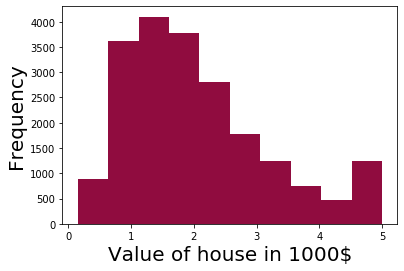

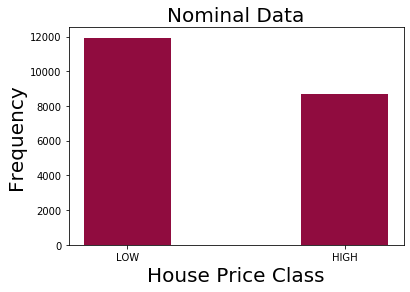

In [29]:
dataset = fetch_california_housing()
# let's look at the data
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
print('Features ')
print(X.columns)
print(f'X.shape: {dataset.data.shape}    y.shape: {dataset.target.shape}')
%matplotlib inline
plt.hist(dataset.target, color=PLOT_COLOR)
plt.xlabel('Value of house in 1000$', fontsize=LABEL_FONTSIZE)
plt.ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.show()

# convert target to labels
labels = np.array([1 if target>CUTOFF else 0 for target in dataset.target])
plt.hist(labels, bins=[-0.2, 0.2, 0.8, 1.2], color=PLOT_COLOR)
plt.xlabel('House Price Class', fontsize=LABEL_FONTSIZE)
plt.ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.xticks([0, 1], ['LOW', 'HIGH'])
plt.title('Nominal Data', fontsize=LABEL_FONTSIZE)
plt.show()

In [30]:
# before investigating the data, split to train and test set to avoid snooping
X_train, X_test, labels_train, labels_test = train_test_split(X, 
                                                              labels, 
                                                              test_size=TEST_SIZE,
                                                              random_state=RANDOM_STATE)

In [31]:
# data exploration
X_train.describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.880754,28.608285,5.435235,1.096685,1426.453004,3.096961,35.643149,-119.582290
std,1.904294,12.602499,2.387375,0.433215,1137.056380,11.578744,2.136665,2.005654
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.692308,32.550000,-124.350000
25%,2.566700,18.000000,4.452055,1.006508,789.000000,2.428799,33.930000,-121.810000
50%,3.545800,29.000000,5.235874,1.049286,1167.000000,2.817240,34.260000,-118.510000
75%,4.773175,37.000000,6.061037,1.100348,1726.000000,3.280000,37.720000,-118.010000
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.310000


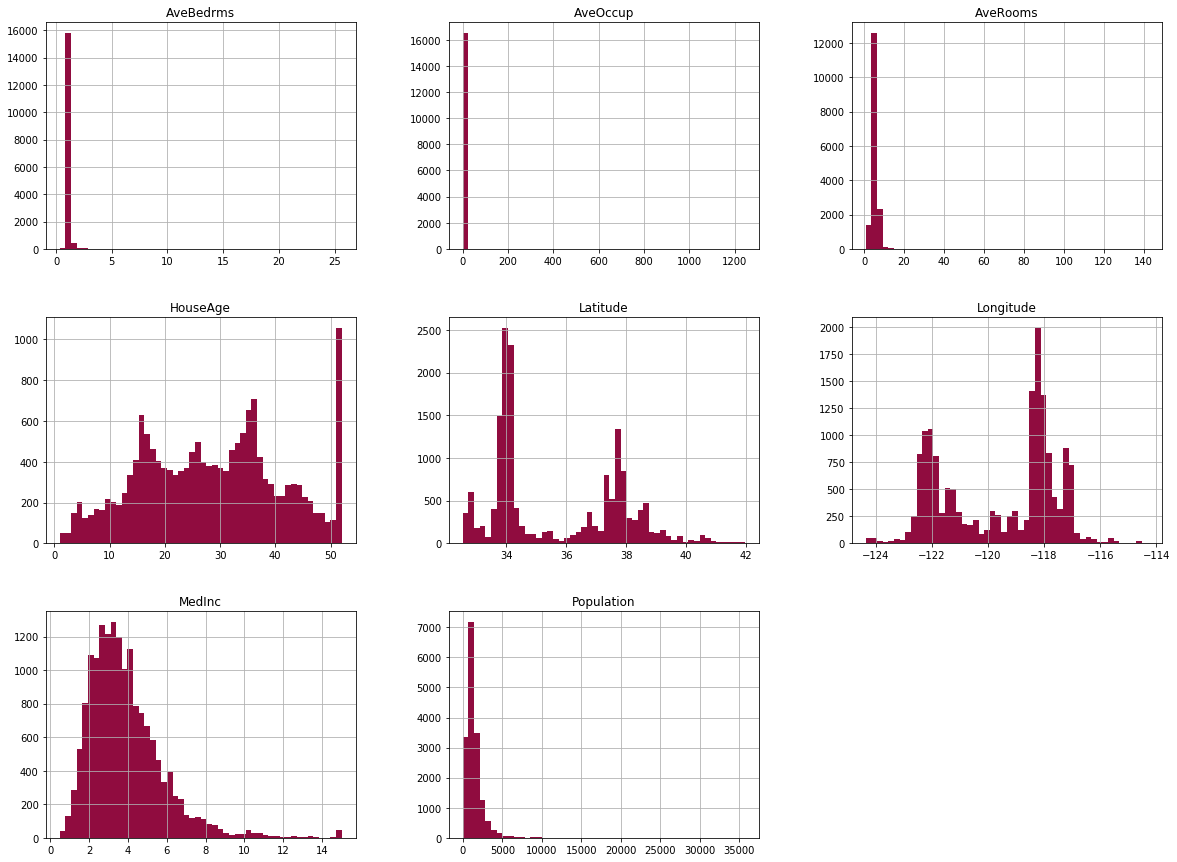

In [32]:
%matplotlib inline
X_train.hist(figsize=(20, 15), color=PLOT_COLOR, bins=50)
plt.show()


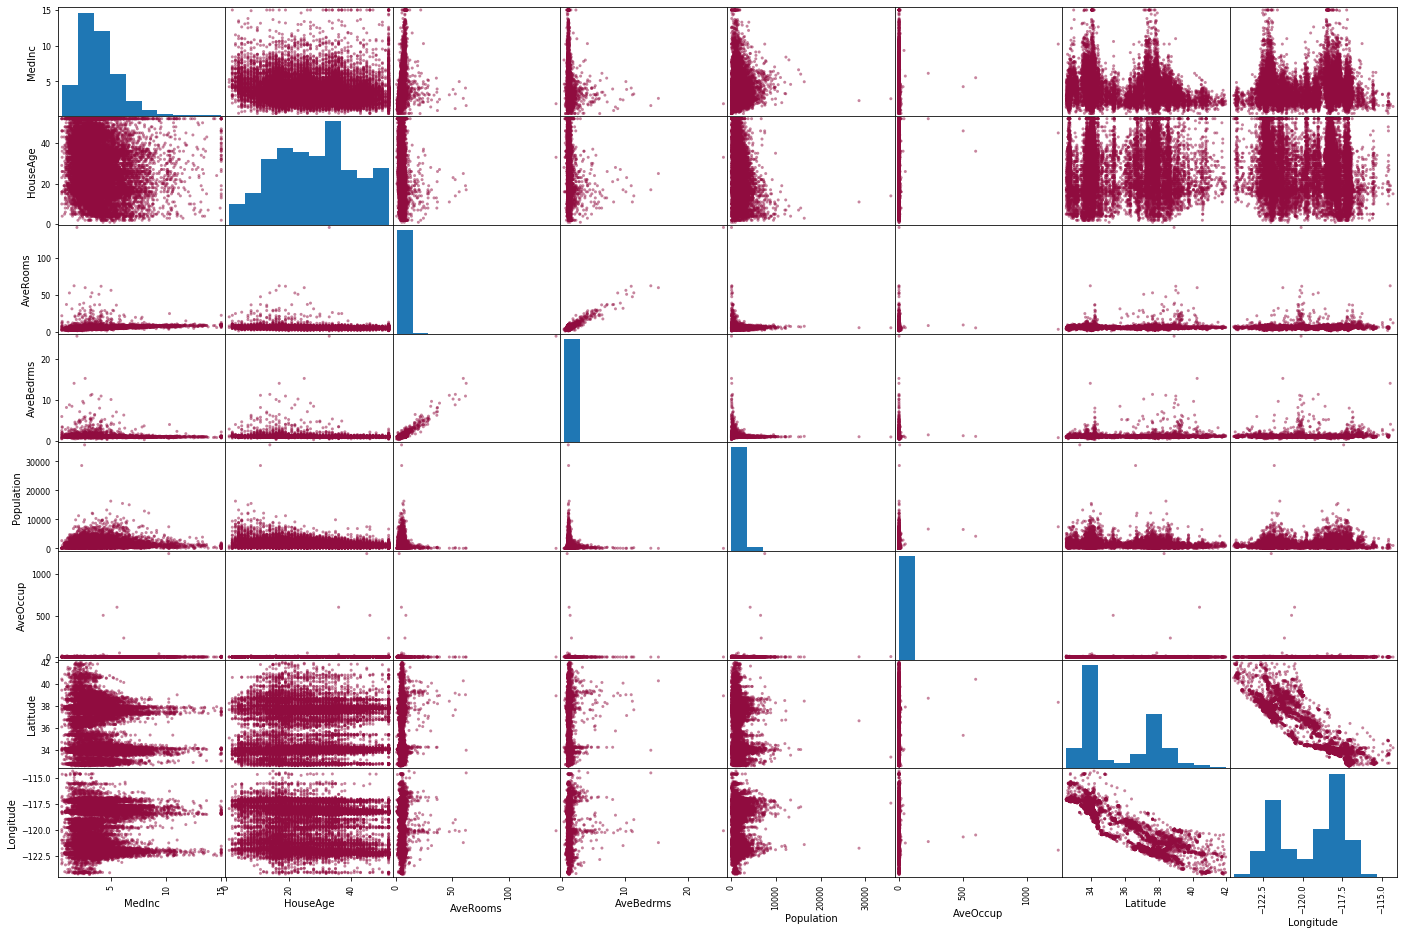

In [33]:
# check for correlations
scatter_matrix(X_train, figsize=(24, 16), color=PLOT_COLOR)
plt.show()

On examination, I get two insights. One: The latitude and longitude scatter resemblesthe state of California. It would be interesting to see if there is a geographical dependence of income.

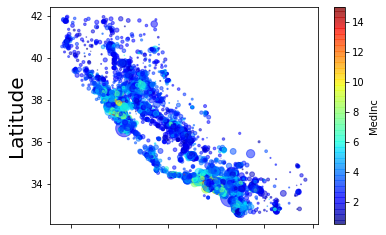

In [34]:
X_train.plot(kind='scatter', 
            x='Longitude', 
            y='Latitude',
            s=X_train["Population"]/100,
            c='MedInc',
            cmap=plt.get_cmap(PLOT_COLORMAP_DIV),
            alpha=0.5,
            colorbar=True)
plt.xlabel('Longitude', fontsize=LABEL_FONTSIZE)
plt.ylabel('Latitude', fontsize=LABEL_FONTSIZE)
plt.show()

The high income groups tend to be on the coast. How about the dependence of the target variable?

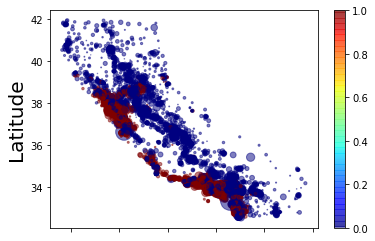

In [35]:
X_train.plot(kind='scatter', 
            x='Longitude', 
            y='Latitude',
            s=X_train["Population"]/100,
            c=labels_train,
            cmap=plt.get_cmap(PLOT_COLORMAP_DIV),
            alpha=0.5,
            colorbar=True)
plt.xlabel('Longitude', fontsize=LABEL_FONTSIZE)
plt.ylabel('Latitude', fontsize=LABEL_FONTSIZE)
plt.show()

Interesting. The high priced houses tend to be towards the coast as well!
The next thing to examine is if the AveOccup descriptor is useful seeing that its histogram just has one bar!

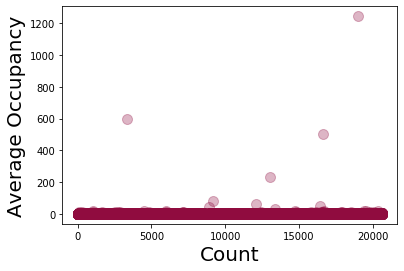

In [36]:
# AveOccup plot
plt.scatter( [_ for _ in range(X.AveOccup.size)],
            X.AveOccup, 
            c=PLOT_COLOR,
           alpha=0.3,
           s=100)
plt.ylabel('Average Occupancy', fontsize=LABEL_FONTSIZE)
plt.xlabel('Count', fontsize=LABEL_FONTSIZE)
plt.show()

Average Occupancy does not seem to be very informative. It also has some very unreasonable values at the high end.
We can decide to dig deeper or drop this to avoid noise in the data. For this tutorial, we don't investigate further.

In [37]:
# create a preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

In [38]:
# some plotting functions
from sklearn.metrics import make_scorer, auc, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_roc(y_test, preds_test, y_train, preds_train, shade=True):
    preds_test = preds_test[:, 1]
    preds_train = preds_train[:, 1]
    # plot test data
    fpr_test, tpr_test, _ = roc_curve(y_test, preds_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.figure(figsize = (10, 10))
    plt.plot(fpr_test,
        tpr_test,
        c=PLOT_COLOR,
        label=' TEST AUC = %0.2f' % roc_auc_test)

    # plot train data
    fpr_train, tpr_train, _ = roc_curve(y_train, preds_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.legend(loc='lower right', fontsize=LEGEND_SIZE)
    plt.plot([0, 1], [0, 1], 'k-.', label='Baseline')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=LABEL_FONTSIZE)
    plt.xlabel('False Positive Rate', fontsize=LABEL_FONTSIZE)
    plt.xticks(size=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    if shade is True:
        plt.fill_between(fpr_test,
            tpr_test, 0,
            alpha=0.5,
            facecolor=PLOT_COLOR)


    plt.show()


def plot_prc(y_test, preds_test, y_train, preds_train, shade=True):
    # plot test data
    preds_test = preds_test[:, 1]
    preds_train = preds_train[:, 1]
    precision_test, recall_test, _ = precision_recall_curve(y_test, preds_test)
    prc_auc_test = auc(recall_test, precision_test)
    plt.figure(figsize = (10, 10))
    plt.plot(
        recall_test, precision_test, color=PLOT_COLOR,
        label=' TEST AUC = %0.2f' % prc_auc_test)

    # plot train data
    precision_train, recall_train, _ = precision_recall_curve(
                                                        y_train, preds_train)
    prc_auc_train = auc(recall_train, precision_train)
    plt.legend(loc='lower right', fontsize=LABEL_FONTSIZE)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision', fontsize=LABEL_FONTSIZE)
    plt.xlabel('Recall', fontsize=LABEL_FONTSIZE)
    plt.xticks(size=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    if shade is True:
        plt.fill_between(recall_test,
            precision_test, 0,
            alpha=0.5,
            facecolor=PLOT_COLOR)
    plt.show()


def plot_confusion_matrix(y_test, class_preds_test, classes,
                          normalize=False, cmap='Reds'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(y_test, class_preds_test)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    sns.heatmap(cm,
                annot=False,
                cmap=cmap,
                cbar=True,
                annot_kws={"size": 28}) # font size
    plt.xlabel('Predicted Class', fontsize=LABEL_FONTSIZE)
    plt.ylabel('Actual Class', fontsize=LABEL_FONTSIZE)
    ax = plt.gca()
    LABELS = ['Low', 'High']
    #ax.set_xticks([0, 1])
    #ax.set_yticks([0, 1])
    ax.set_xticklabels(LABELS, fontsize=TICK_SIZE)
    ax.set_yticklabels(LABELS, fontsize=TICK_SIZE)
    plt.show()

<b> Logistic Regression </b>

Logistic regression is the same as linear regression, with the output of the linear regresssion 'squished' to a value between 0 and 1 usingthe logistic function: f(t) = 1 / (1 + exp(-t)). This value between 0 and 1 is interpreted as a probability. Thus this can be only used for binary classification where this number in (0, 1) represents the probability of belonging to one class.

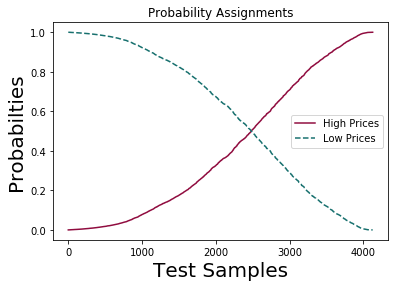

In [39]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, labels_train)

# let's predict test data
predicted_test_proba = log_reg.predict_proba(X_test) # these are probabilities
predicted_test_labels = log_reg.predict(X_test) # these are predicted classea

sorted_proba = predicted_test_proba[np.argsort(predicted_test_proba[:, 1])]
plt.plot([_ for _ in range(sorted_proba[:, 1].size)], 
         sorted_proba[:, 1], 
         c=PLOT_COLOR,
         label='High Prices')
plt.plot([_ for _ in range(sorted_proba[:, 1].size)], 
         sorted_proba[:, 0], 
         color=ALT_COLOR,
         linestyle="--", 
         label='Low Prices')
plt.legend()
plt.xlabel('Test Samples', fontsize=LABEL_FONTSIZE)
plt.ylabel('Probabilties', fontsize=LABEL_FONTSIZE)
plt.title('Probability Assignments')
plt.show()

Now we evaluate the performance

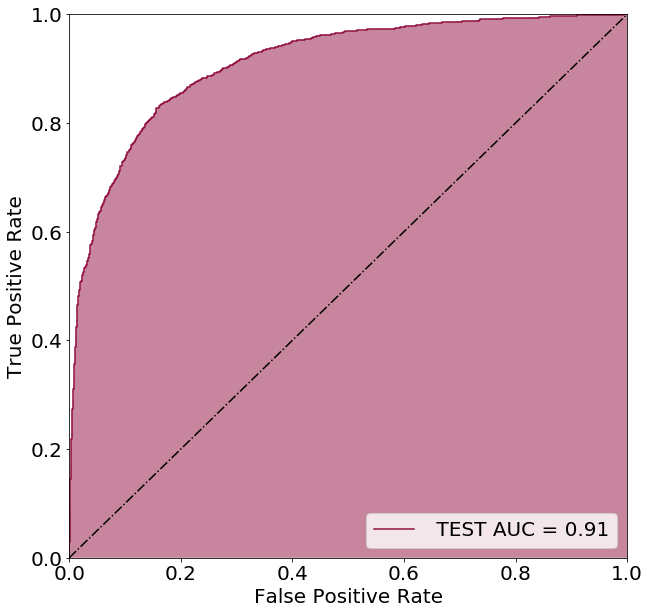

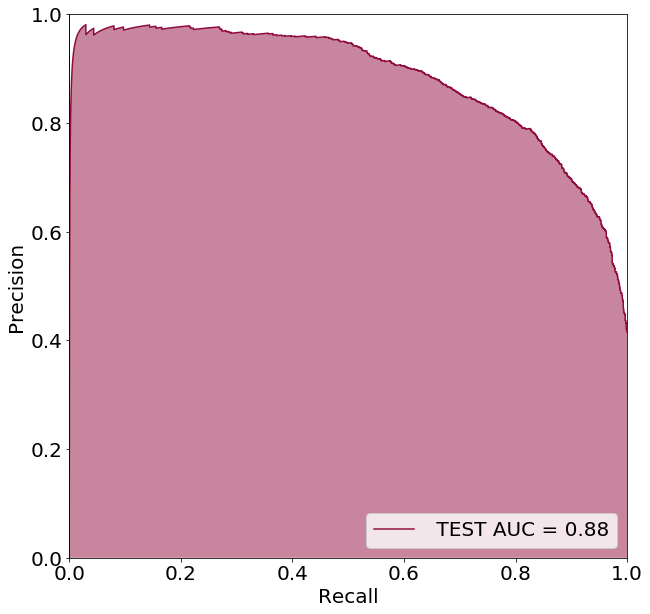

Confusion matrix, without normalization
[[2112  309]
 [ 370 1337]]


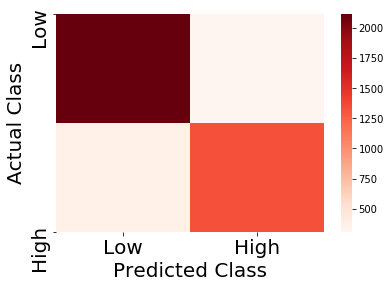

In [42]:

plot_roc(labels_test, predicted_test_proba, labels_train, log_reg.predict_proba(X_train))
plot_prc(labels_test, predicted_test_proba, labels_train, log_reg.predict_proba(X_train))
plot_confusion_matrix(labels_test, 
                      predicted_test_labels, 
                      classes=['Low Response', 'High Response'])


This is good but because of the simplicity of the model, it cannot fit complex, non-linear data.
Let's take a look at a more advanced Random Forest algorithm!

<b> Random Forest </b>

We will now look at an algorithm called random forest which builds a series of decision trees based on different features of the data to try and classify the input into the different classes.

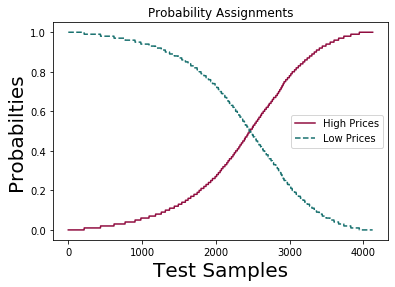

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, labels_train)

# let's predict test data
predicted_test_proba = rf.predict_proba(X_test) # these are probabilities
predicted_test_labels = rf.predict(X_test) # these are predicted classea

sorted_proba = predicted_test_proba[np.argsort(predicted_test_proba[:, 1])]
plt.plot([_ for _ in range(sorted_proba[:, 1].size)], 
         sorted_proba[:, 1], 
         c=PLOT_COLOR,
         label='High Prices')
plt.plot([_ for _ in range(sorted_proba[:, 1].size)], 
         sorted_proba[:, 0], 
         color=ALT_COLOR,
         linestyle="--", 
         label='Low Prices')
plt.legend()
plt.xlabel('Test Samples', fontsize=LABEL_FONTSIZE)
plt.ylabel('Probabilties', fontsize=LABEL_FONTSIZE)
plt.title('Probability Assignments')
plt.show()

Let's see how well it does on the test set!

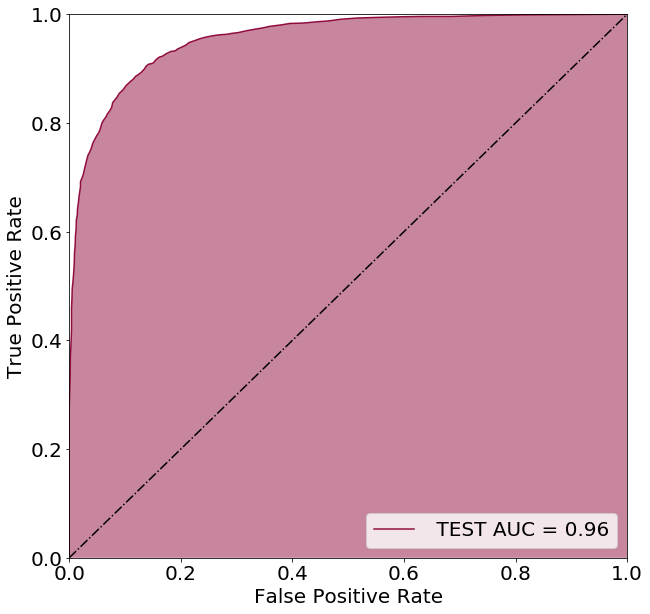

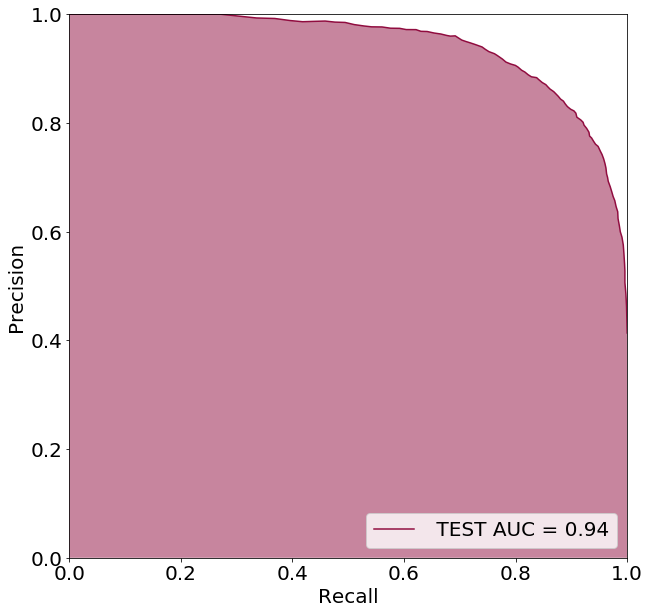

Confusion matrix, without normalization
[[2213  208]
 [ 260 1447]]


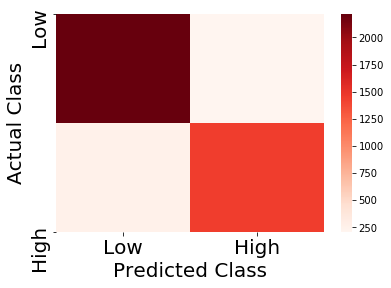

In [45]:
plot_roc(labels_test, predicted_test_proba, labels_train, rf.predict_proba(X_train))
plot_prc(labels_test, predicted_test_proba, labels_train, rf.predict_proba(X_train))
plot_confusion_matrix(labels_test, 
                      predicted_test_labels, 
                      classes=['Low Response', 'High Response'])

We get some improvement over the simple logistic regression. In reality, we can probably get even better with hyperparameter optimization!